In [1]:
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

import sys
sys.path.append('..')
from unitednet.interface import UnitedNet
from unitednet.configs import *
from unitednet.data import partitions,save_umap,generate_adata
from unitednet.scripts import ordered_cmat,assignmene_align
import copy as copy


In [2]:
technique = 'ATAC_seq'
data_path = f"../data/{technique}"
root_save_path = f"../saved_results/atacseq_new_trans_finetune_v2"
test_batches = ['s1d1', 's1d2', 's1d3',
 's2d1', 's2d4', 's2d5',
 's3d3', 's3d6', 's3d7', 's3d10',
 's4d1', 's4d8', 's4d9']
device = "cuda:0"

In [3]:

adata_atac = sc.read_h5ad(f'{data_path}/atac_processed.h5ad')
adata_atac.X = adata_atac.X.toarray()
adata_atac.obs['label'] = list(adata_atac.obs['cell_type'])
adata_atac.var['original_var'] = adata_atac.var_names
adata_atac.var_names = np.append(pd.read_csv(f'{data_path}/annotated_ATAC_gene_names_10k.csv').iloc[:,0].values,'unknown')
adata_atac.var_names_make_unique()
adata_atac.var_names = adata_atac.var_names.astype(str)
adata_gex  = sc.read_h5ad(f'{data_path}/gex_processed.h5ad')
adata_gex.obs['label'] = list(adata_gex.obs['cell_type'])



In [4]:
adatas_all = [adata_atac,adata_gex]
print(adata_atac.var_names)

Index(['LOC101928626', 'LINC01128', 'LINC02593', 'LINC02593-1', 'NOC2L',
       'ISG15', 'AGRN', 'C1orf159', 'C1orf159-1', 'LINC01342',
       ...
       'PLXNA3', 'UBL4A', 'GAB3', 'GAB3-1', 'MPP1', 'F8', 'CMC4', 'VBP1',
       'RAB39B', 'unknown'],
      dtype='object', length=13634)


# Robustness analysis for the relevance analysis

In [5]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score,adjusted_rand_score

import shap
import torch
import torch.nn as nn
from unitednet.modules import submodel_trans, submodel_clus
from unitednet.data import save_obj, load_obj, partitions, type_specific_mean
from unitednet.plots import markers_chord_plot,type_relevance_chord_plot,feature_relevance_chord_plot,merge_sub_feature



In [7]:
test_batches = ['s1d1']

s1d1


Trying to modify attribute `.obs` of view, initializing view as actual.
Trying to modify attribute `.obs` of view, initializing view as actual.


B cells
['TMEM52' 'RNU5E-1-1' 'MAN1C1' 'PAFAH2-2' 'CCDC163' 'CKS1B' 'AIM2-1'
 'RGS2' 'TMCC2-4' 'ADARB2-AS1-2' 'WDFY4' 'HHEX' 'LOC101928053' 'INTS4'
 'YBX3' 'TMEM263' 'KDM2B' 'ZNF664-RFLNA' 'MTMR6' 'PIP4P1' 'RPS29'
 'SYNE2-2' 'BTBD7' 'SNHG10' 'PATL2-1' 'TMEM202-AS1-1' 'LINC02255' 'CEMIP'
 'MIR549A' 'MAPK8IP3' 'ERVK13-1' 'ATP6V0D1' 'MYO1C-2' 'MTRNR2L1' 'RARA-2'
 'C17orf99-1' 'RBFADN' 'AP3D1' 'GNG7' 'TIMM44' 'PRKACA' 'CPAMD8' 'KLHL26'
 'CCDC61' 'SYNGR4' 'POLD1' 'CTU1' 'DNAJC27' 'STPG4' 'XPO1-1' 'GMCL1'
 'TMEM87B' 'PYGB' 'ZNF831' 'CENPM' 'SLC4A7' 'NKTR' 'QTRT2' 'ANAPC13'
 'STAG1-1' 'XXYLT1-3' 'ACAP2' 'FAM90A26' 'RASGEF1B-2' 'ADTRP' 'JARID2-4'
 'HCG27' 'KCNK16' 'TAGAP-2' 'GLCCI1-DT' 'TBL2' 'HIP1-1' 'BLK' 'CTSB'
 'LOC101929294' 'NCOA2-1' 'LINC01410' 'STOM' 'ARRDC1' 'ST6GALNAC3' 'FCRL1'
 'AIM2' 'SLAMF7' 'RALGPS2' 'MIR181A1HG' 'EML6' 'IGKC' 'AFF3' 'ADAM23'
 'COL4A4' 'OSBPL10' 'ARPP21' 'CCDC191' 'MME' 'FNDC3B' 'JCHAIN' 'PARM1'
 'ARHGAP24' 'BANK1' 'CAMK2D' 'LARP1B' 'TBC1D9' 'MARCH1' 'PDE4D' 'SSB

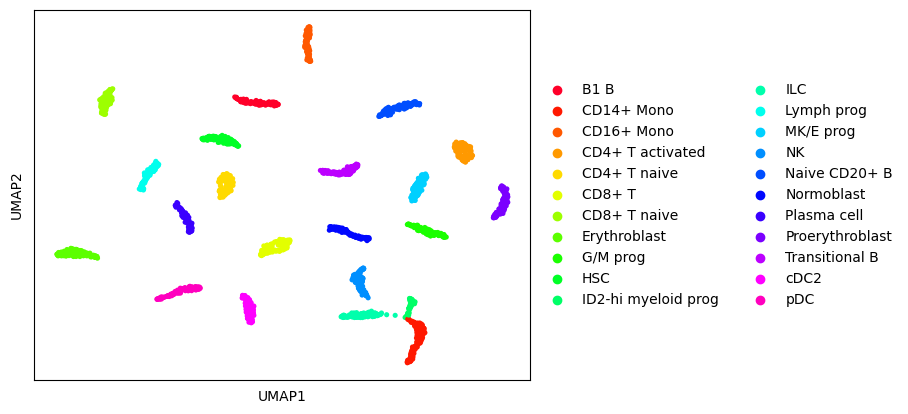

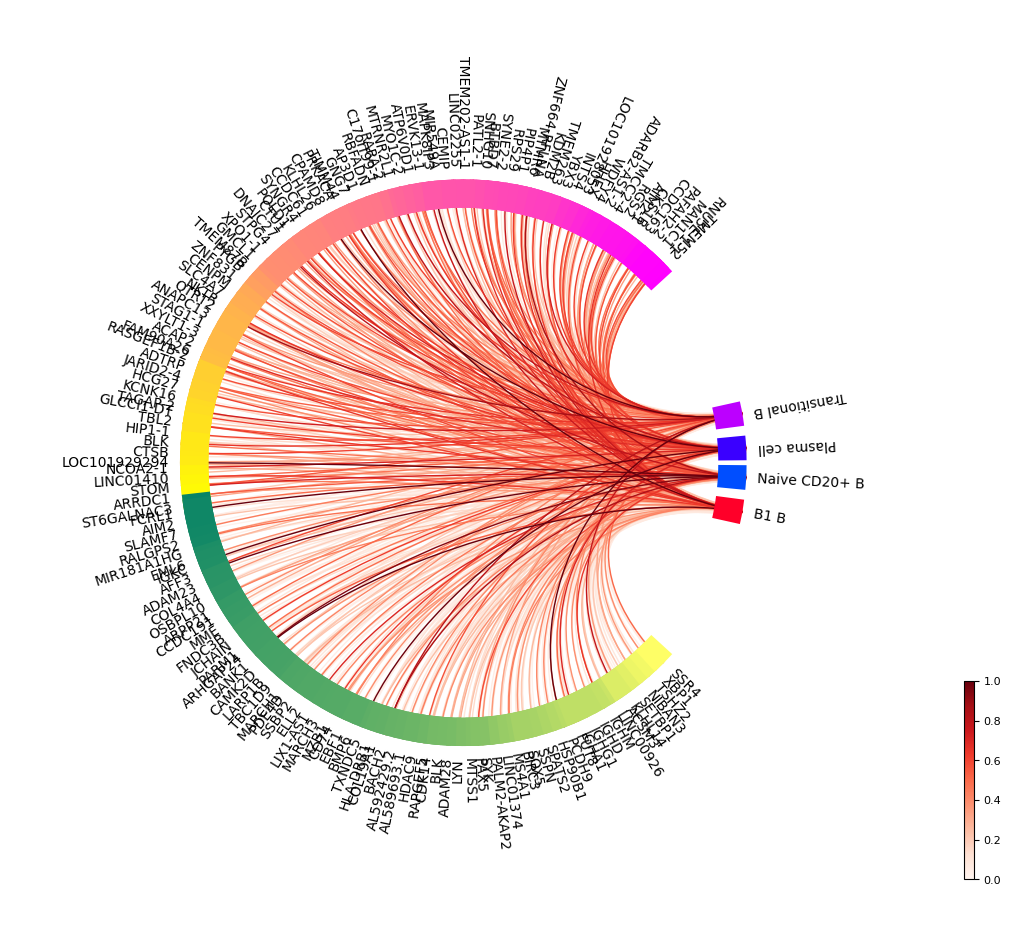

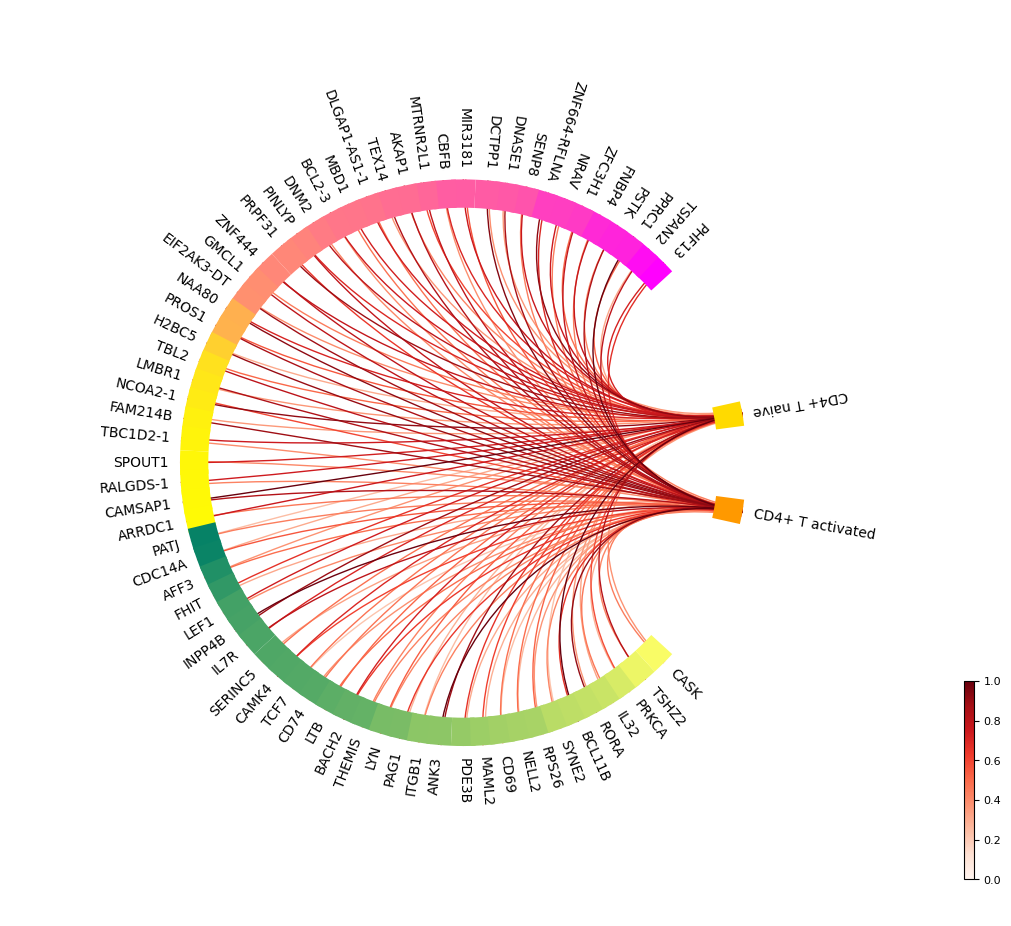

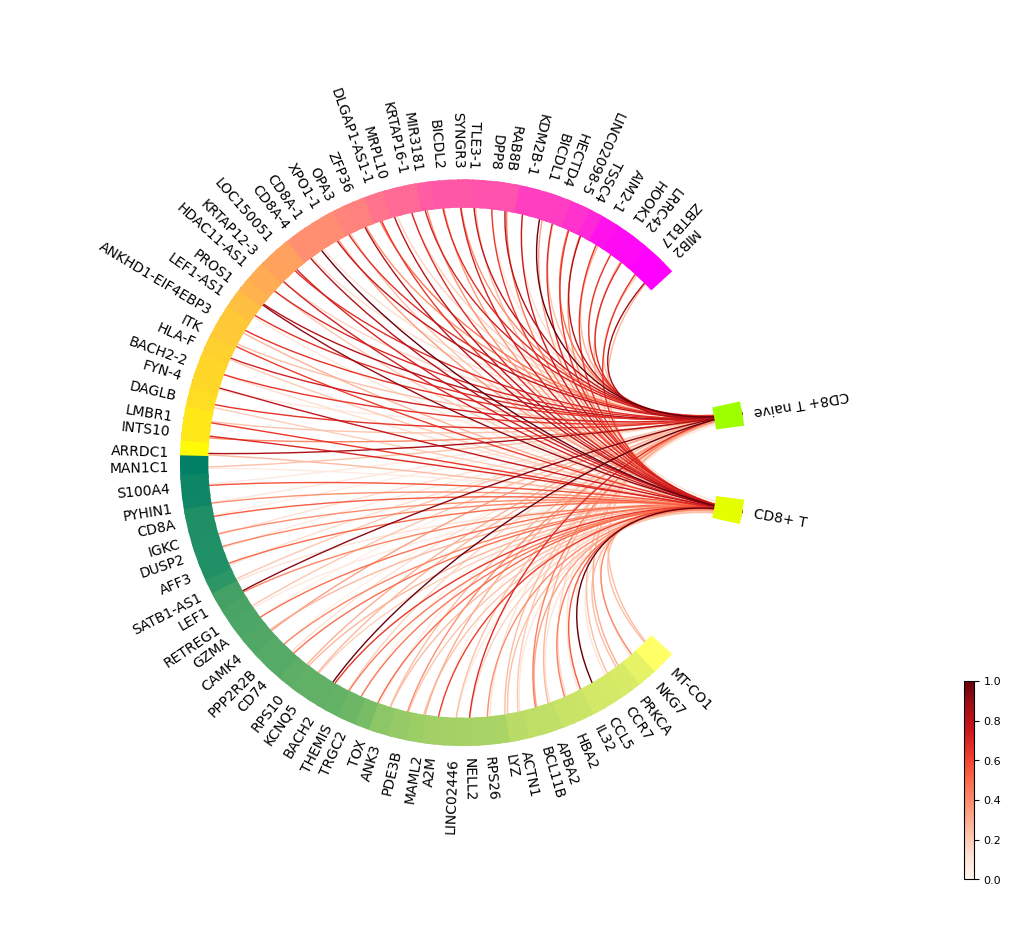

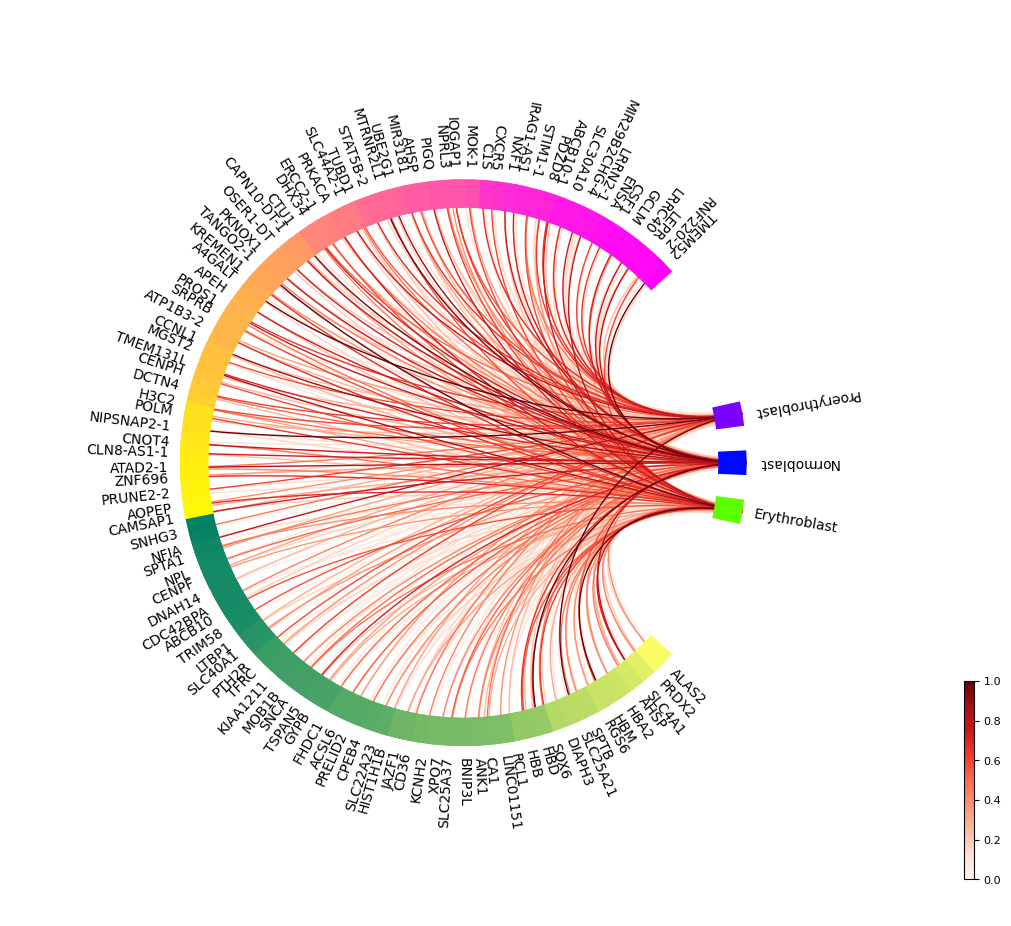

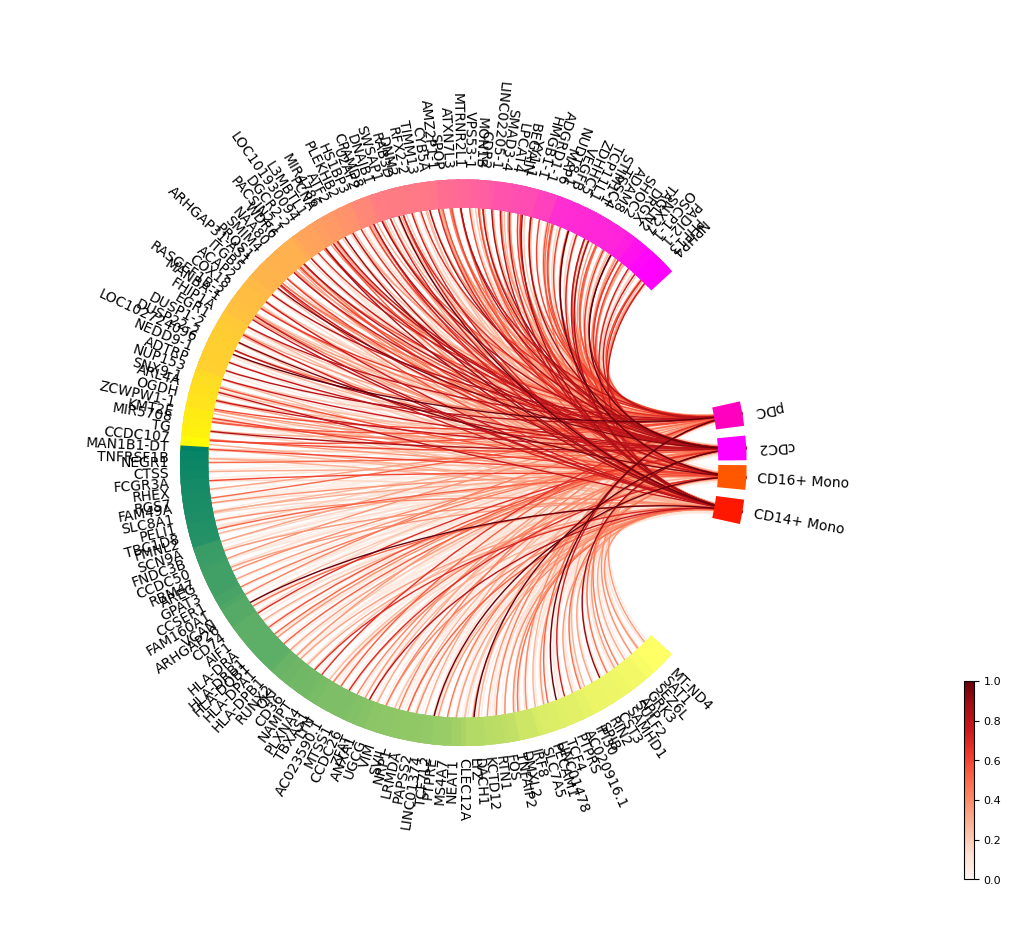

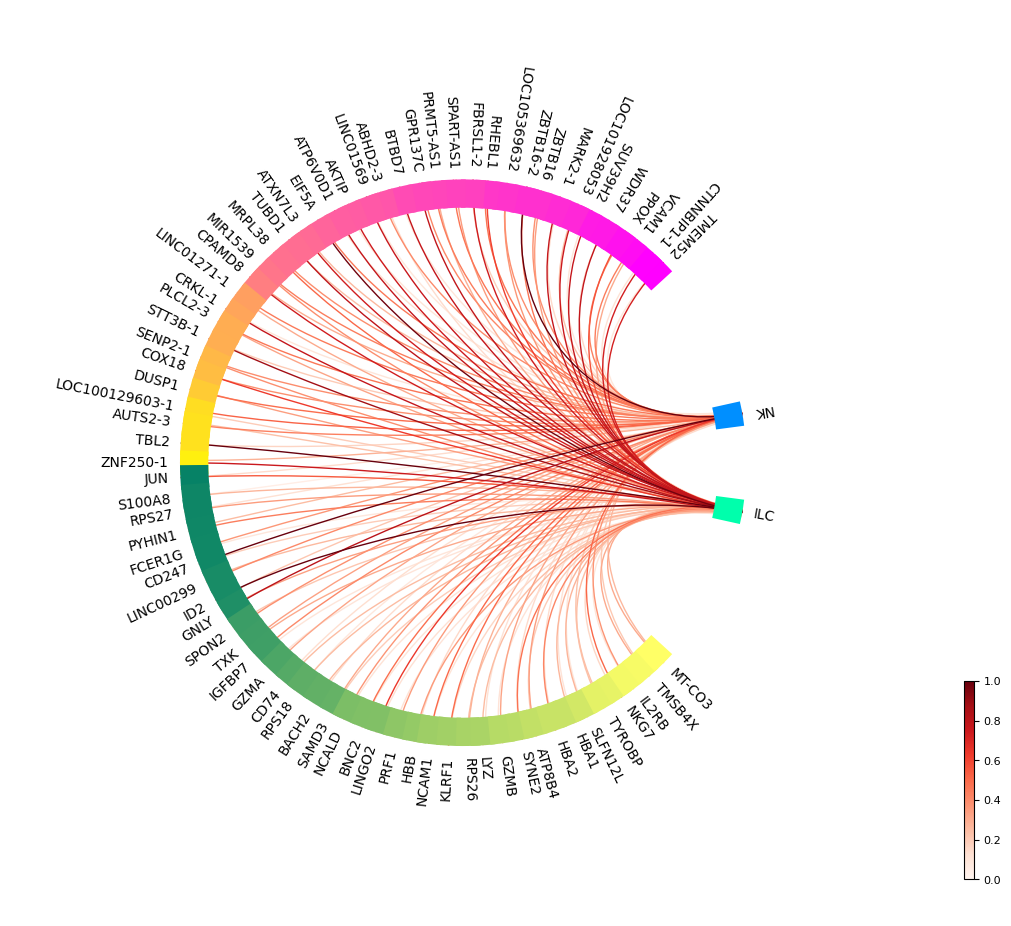

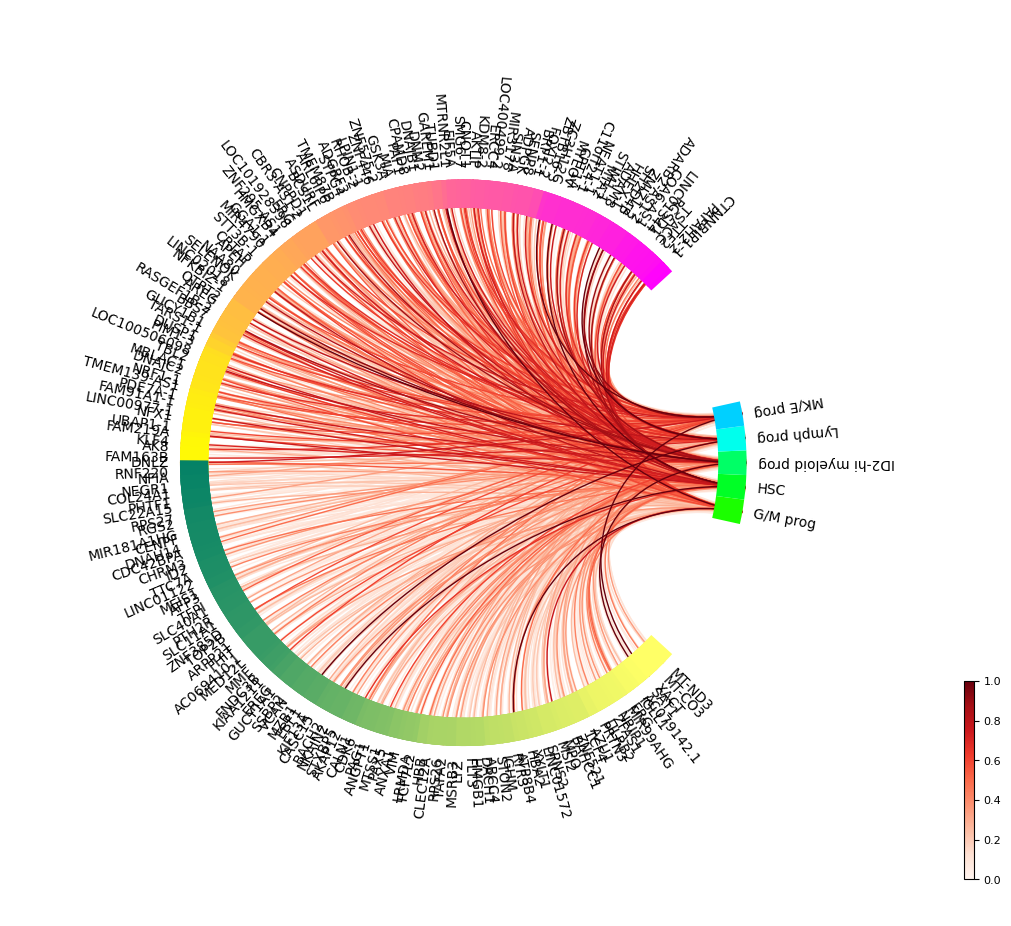

In [9]:
accuracy_matching = []
type_feature = {}
type_feature_major = {}
feature_relevance = {}
type_feature_shap_values = []

modality_names = ['ATAC','RNA']

adatas_all = [adata_atac,adata_gex]


for test_batch in test_batches:
    print(test_batch)
    model = UnitedNet(f"{root_save_path}/{test_batch}", device=device, technique=atacseq_config)
    model.load_model(f"{root_save_path}/{test_batch}/transfer_best.pt",device=device)

    calculate_shap=False

    cluster_prototype_features = [type_specific_mean(ad_x,'label').to(device=model.device) for ad_x in adatas_all]


    shap_value_target = {}

    sp_idx = adatas_all[0].obs.groupby(["label"]).sample(n=100, random_state=1).index
    test_type = [torch.tensor(adatas_all[0][sp_idx].X,device=model.device), torch.tensor(adatas_all[1][sp_idx].X,device=model.device)]

    adatas_all = [ad_x[sp_idx] for ad_x in adatas_all]
    predict_label = model.predict_label(adatas_all)
    adata_fused = model.infer(adatas_all)
    predict_label_anno = adata_fused.obs['predicted_label']
    adata_fused.obs['label'] = list(adatas_all[0].obs['label'])
    ct_num = len(adatas_all[0].obs["label"].unique())
    
    root_save_path_relev = f'{root_save_path}/{test_batch}/type_relevance'
    if calculate_shap:
        sub = submodel_clus(model.model).to(model.device)
        # select a set of background examples to take an expectation over
        background = cluster_prototype_features
        e = shap.DeepExplainer(sub, background)
        # choose what to explain
        shap_values = e.shap_values(test_type,check_additivity=True)
        save_obj(root_save_path_relev,f'type_explain',shap_values)
    else:
        shap_values = load_obj(root_save_path_relev,f'type_explain', ct_num,
                              [ads.shape for ads in adatas_all],type_rele=True,mod_num=2)
    type_feature_shap_values.append(shap_values)

 
    major_dict = {'CD14+ Mono': 'Monocytes', 
                  'CD16+ Mono': 'Monocytes',
                  'pDC': 'Monocytes', 
                  'cDC2': 'Monocytes',
                  'Naive CD20+ B': 'B cells', 
                  'B1 B': 'B cells', 
                  'Transitional B': 'B cells', 
                  'Plasma cell': 'B cells',
                  'HSC': 'Progenitors', 
                  'ID2-hi myeloid prog': 'Progenitors', 
                  'Lymph prog': 'Progenitors', 
                  'MK/E prog': 'Progenitors',
                  'G/M prog': 'Progenitors',
                  'Proerythroblast': 'Erythropoiesis', 
                  'Erythroblast': 'Erythropoiesis', 
                  'Normoblast': 'Erythropoiesis',
                  'CD4+ T naive': 'CD4+ T cells', 
                  'CD4+ T activated': 'CD4+ T cells', 
                  'CD8+ T': 'CD8+ T cells',
                  'CD8+ T naive': 'CD8+ T cells', 
                  'NK': 'NK cells', 
                  'ILC': 'NK cells'}
    adatas_all_new,p_fe,p_fe_idx,p_l_less,pr_ty_dict = markers_chord_plot(adatas_all,predict_label,predict_label_anno,major_dict,subset_feature=False)
    all_less_type = np.unique(p_l_less)

    if 'predicted_label_colors' not in adata_fused.uns.keys():
        sc.pl.umap(adata_fused,color=['predicted_label'],palette='gist_rainbow',show=False,title='')
    colors_type = dict(zip(adata_fused.obs['predicted_label'].cat.categories,adata_fused.uns['predicted_label_colors']))
    all_type_features, _, _ = type_relevance_chord_plot(shap_values, p_fe, p_fe_idx, p_l_less,predict_label, colors_type, all_less_type,f'{test_batch}_{technique}',
                                  pr_ty_dict,thres=20,only_show_good=True, linewidth=1, linecolormap='Reds', node_width=5,fontsize_names=10,
                                  potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])
    print(all_type_features)
    type_feature[test_batch] = all_type_features
    all_type_features_mj = merge_sub_feature(all_type_features,major_dict)
    type_feature_major[test_batch] = all_type_features_mj


In [9]:
import pickle


In [10]:

with open('./saved_results/atac_seq_type_relevance_robust.pkl', 'wb') as handle:
    pickle.dump(type_feature, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./saved_results/atac_seq_type_major_relevance_robust.pkl', 'wb') as handle:
    pickle.dump(type_feature_major, handle, protocol=pickle.HIGHEST_PROTOCOL)




FileNotFoundError: [Errno 2] No such file or directory: './saved_results/atac_seq_type_relevance_robust.pkl'

In [12]:


with open('./saved_results/atac_seq_type_relevance_robust.pkl', 'rb') as handle:
    type_feature = pickle.load(handle)

with open('./saved_results/atac_seq_type_major_relevance_robust.pkl', 'rb') as handle:
    type_feature_major = pickle.load(handle)


FileNotFoundError: [Errno 2] No such file or directory: './saved_results/atac_seq_type_relevance_robust.pkl'

# check how overlapping the feature names are between each cross validation

In [10]:
from functools import reduce

In [11]:
mj_types = ['B cells', 'CD4+ T cells', 'CD8+ T cells', 'Erythropoiesis',
       'Monocytes', 'NK cells', 'Progenitors']

In [12]:
d_feature = {}
r_feature = {}
for ct in mj_types:
    d_feature[ct] = {'feature_name':[],'test_batch':[]}
    r_feature[ct] = {'feature_name':[],'test_batch':[]}
    for test_batch in test_batches: 
        d_feature[ct]['feature_name'].append(type_feature_major[test_batch][ct][0])
        r_feature[ct]['feature_name'].append(type_feature_major[test_batch][ct][1])

        d_feature[ct]['test_batch'].append([test_batch]*len(type_feature_major[test_batch][ct][0]))
        r_feature[ct]['test_batch'].append([test_batch]*len(type_feature_major[test_batch][ct][1]))

    d_feature[ct]['test_batch'] = np.hstack(d_feature[ct]['test_batch'])
    r_feature[ct]['test_batch'] = np.hstack(r_feature[ct]['test_batch'])

    d_feature[ct]['feature_name'] = np.hstack(d_feature[ct]['feature_name'])
    r_feature[ct]['feature_name'] = np.hstack(r_feature[ct]['feature_name'])


# predictability comparison between SHAP identified features and other features

In [13]:
import matplotlib as mpl
from  matplotlib.ticker import FuncFormatter
mpl.rcParams['font.family'] = 'Arial'
sns.set_theme(style="ticks")
thres = 20
type_feature_cv = {'D':{},'R':{}}




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.





Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



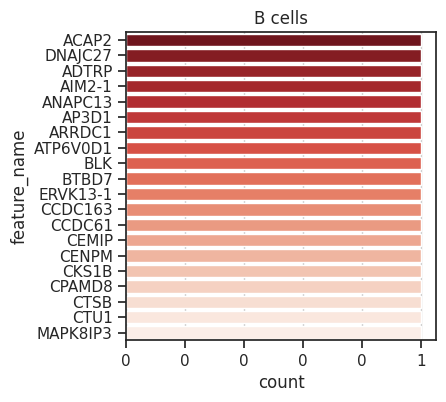

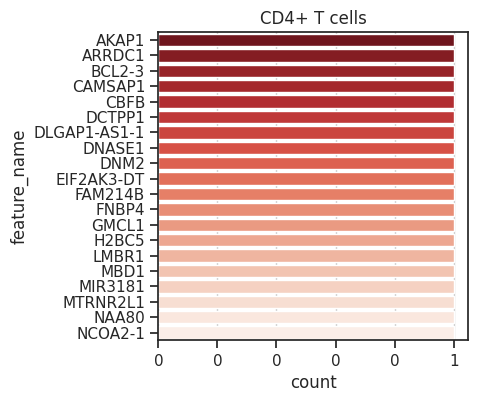

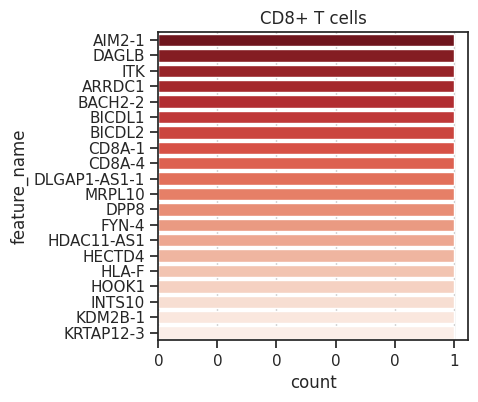

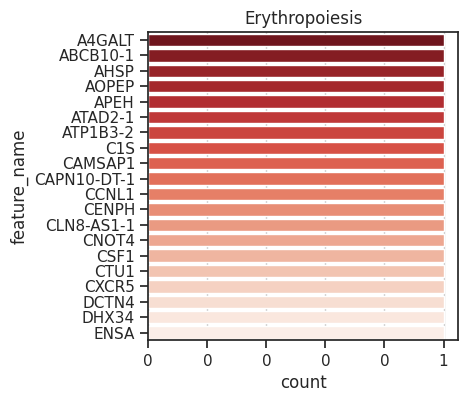

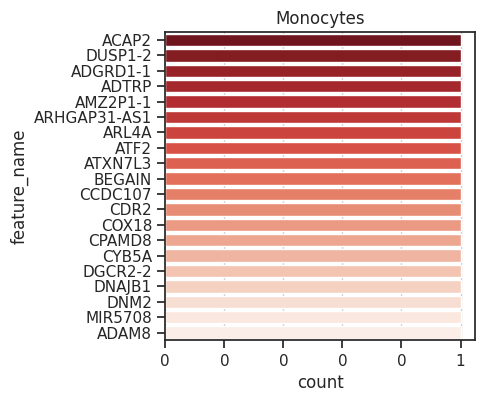

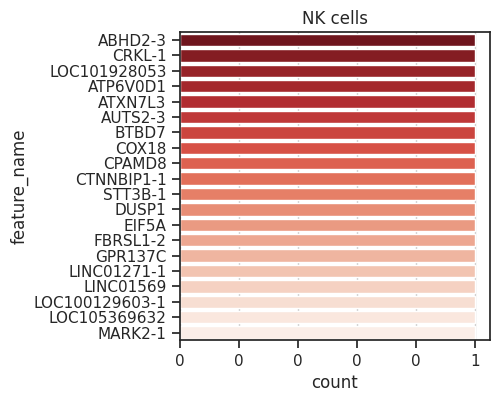

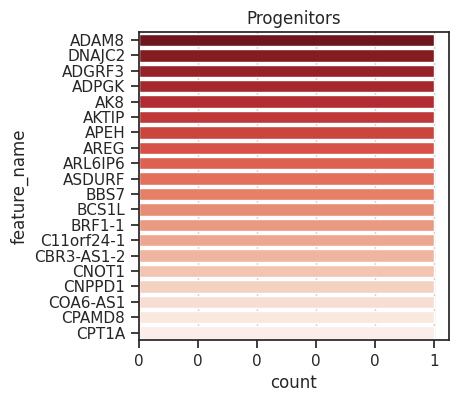

In [14]:
for ct in mj_types:
    fig,ax = plt.subplots(figsize=[4,4])
    ct_ct = pd.DataFrame(d_feature[ct])['feature_name'].value_counts().sort_values(ascending=False)
    x_order = ct_ct.index
    sns.countplot(data = d_feature[ct],y='feature_name',order = x_order[:thres],
                  palette='Reds_r',ax=ax)
    plt.grid(axis='x')
    plt.title(ct)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.savefig(f'./shap_robustness/atacseq/type_relevance_{ct}_D.pdf')
    type_feature_cv['D'][ct] = ct_ct[:thres].index.to_numpy()
    



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same e

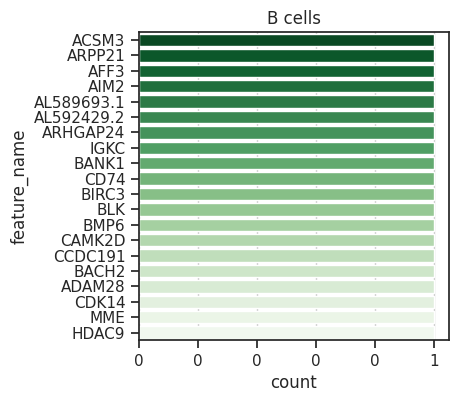

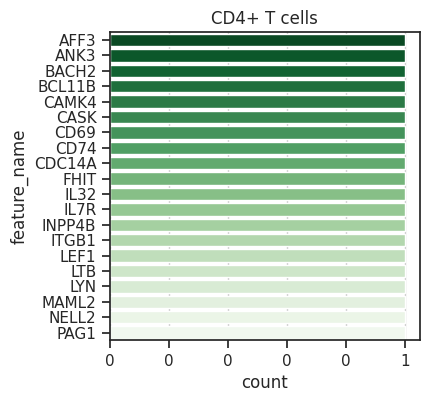

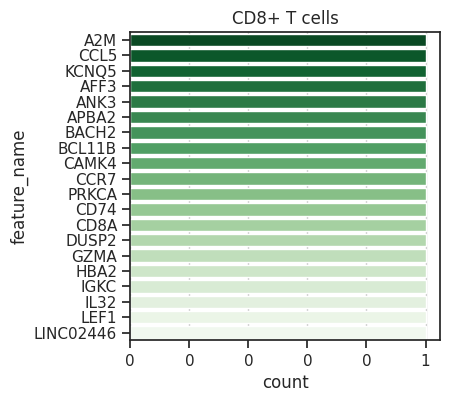

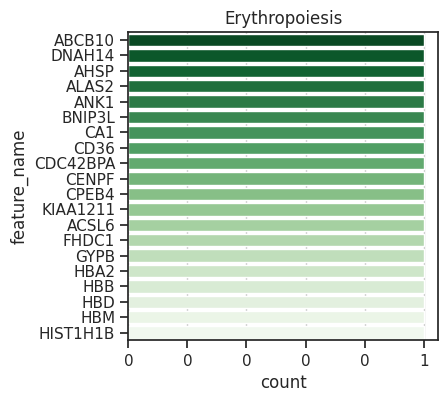

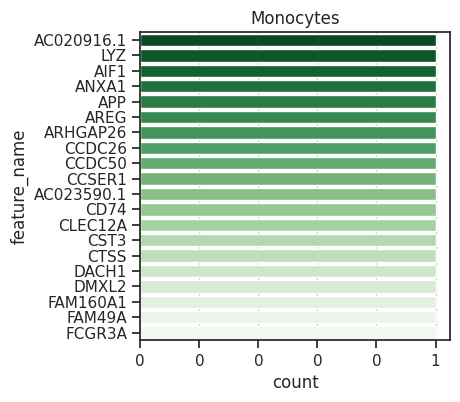

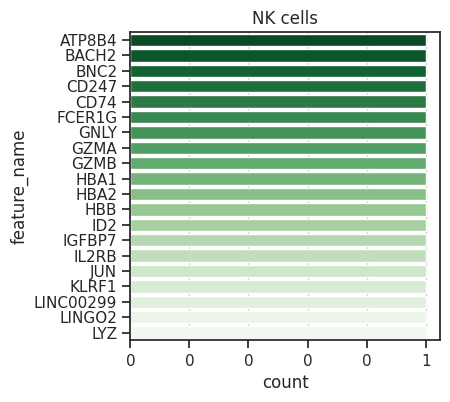

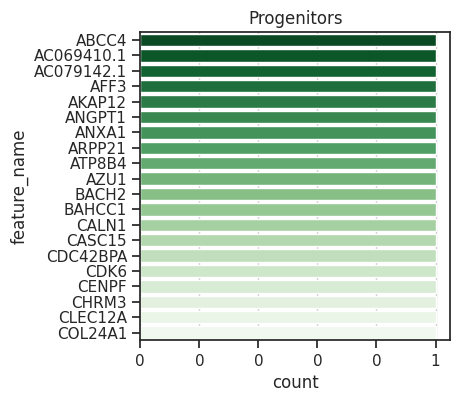

In [15]:

for ct in mj_types:
    fig,ax = plt.subplots(figsize=[4,4])
    ct_ct = pd.DataFrame(r_feature[ct])['feature_name'].value_counts().sort_values(ascending=False)
    x_order = ct_ct.index
    sns.countplot(data = r_feature[ct],y='feature_name',order = x_order[:thres],
                  palette='Greens_r',ax=ax)
    plt.grid(axis='x')
    plt.title(ct)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.savefig(f'./shap_robustness/atacseq/type_relevance_{ct}_R.pdf')
    type_feature_cv['R'][ct] = ct_ct[:thres].index.to_numpy()


# Cross validated type-feature relevance plot

In [16]:
type_feature_shap_avg = []
for ct in range(22):
    ct_vl = []
    for mod in range(2):
        ct_mod_vl = []
        for cv in range(13):
            ct_mod_vl.append(type_feature_shap_values[cv][ct][mod])
        ct_vl.append(np.mean(ct_mod_vl,axis=0))
    type_feature_shap_avg.append(ct_vl)



IndexError: list index out of range

In [17]:

for test_batch in [test_batches[0]]:
    print(test_batch)
    model = UnitedNet(f"{root_save_path}/{test_batch}", device=device, technique=atacseq_config)
    model.load_model(f"{root_save_path}/{test_batch}/transfer_best.pt",device=torch.device(device))
    model.model.device_in_use = device
    adatas_all = [adata_atac,adata_gex]

    calculate_shap=False

    cluster_prototype_features = [type_specific_mean(ad_x,'label').to(device=model.device) for ad_x in adatas_all]

    modality_names = ['ATAC','RNA']

    shap_value_target = {}

    sp_idx = adatas_all[0].obs.groupby(["label"]).sample(n=100, random_state=1).index
    test_type = [torch.tensor(adatas_all[0][sp_idx].X,device=model.device), torch.tensor(adatas_all[1][sp_idx].X,device=model.device)]

    adatas_all = [ad_x[sp_idx] for ad_x in adatas_all]
    predict_label = model.predict_label(adatas_all)
    adata_fused = model.infer(adatas_all)
    predict_label_anno = adata_fused.obs['predicted_label']
    adata_fused.obs['label'] = list(adatas_all[0].obs['label'])
    major_dict = {'CD14+ Mono': 'Monocytes', 
                  'CD16+ Mono': 'Monocytes',
                  'pDC': 'Monocytes', 
                  'cDC2': 'Monocytes',
                  'Naive CD20+ B': 'B cells', 
                  'B1 B': 'B cells', 
                  'Transitional B': 'B cells', 
                  'Plasma cell': 'B cells',
                  'HSC': 'Progenitors', 
                  'ID2-hi myeloid prog': 'Progenitors', 
                  'Lymph prog': 'Progenitors', 
                  'MK/E prog': 'Progenitors',
                  'G/M prog': 'Progenitors',
                  'Proerythroblast': 'Erythropoiesis', 
                  'Erythroblast': 'Erythropoiesis', 
                  'Normoblast': 'Erythropoiesis',
                  'CD4+ T naive': 'CD4+ T cells', 
                  'CD4+ T activated': 'CD4+ T cells', 
                  'CD8+ T': 'CD8+ T cells',
                  'CD8+ T naive': 'CD8+ T cells', 
                  'NK': 'NK cells', 
                  'ILC': 'NK cells'}

s1d1


Trying to modify attribute `.obs` of view, initializing view as actual.
Trying to modify attribute `.obs` of view, initializing view as actual.
invalid value encountered in log


IndexError: list index out of range

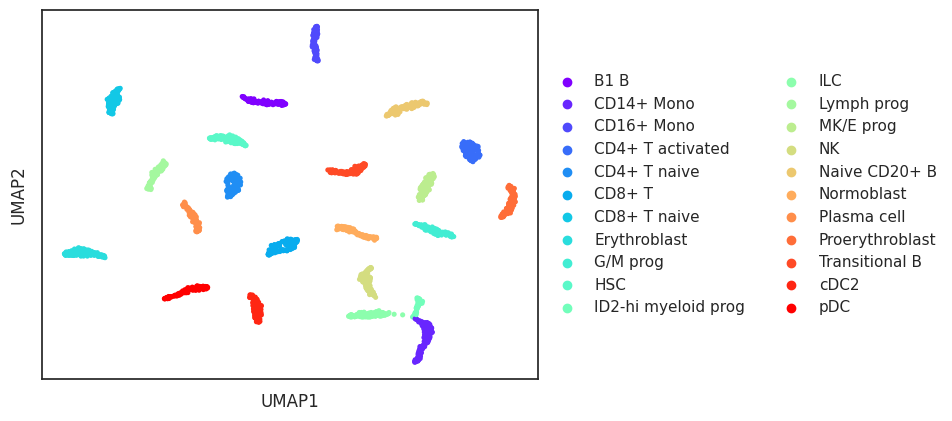

In [18]:



adatas_all_new,_,_,p_l_less,pr_ty_dict = markers_chord_plot(adatas_all,predict_label,predict_label_anno,major_dict)

for ct in mj_types:
    p_fe = [type_feature_cv[mod][ct] for mod in ['D','R']]
    p_fe_idx = [np.in1d(adatas_all[i].var_names, p_fe[i]) for i in range(2)]


    all_less_type = [ct]

    if 'predicted_label_colors' not in adata_fused.uns.keys():
        sc.pl.umap(adata_fused,color=['predicted_label'],palette='rainbow',show=False,title='')
    colors_type = dict(zip(adata_fused.obs['predicted_label'].cat.categories,adata_fused.uns['predicted_label_colors']))
    all_type_features = type_relevance_chord_plot(type_feature_shap_avg, p_fe, p_fe_idx, p_l_less,predict_label, colors_type, all_less_type,f'{technique}_{ct}',
                                  pr_ty_dict,thres=0.0,only_show_good=True, linewidth=1, linecolormap='Reds', node_width=5,
                                  potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])



# cell type specific cross-modal feature-to-feature relevance

In [19]:
calculate_shap = True
#Runtime of the program is 9307.601849794388
cluster_prototype_0_1 = type_specific_mean(adata_atac,'label').to(device=model.device)
# select a set of background_0_1 examples to take an expectation over
background_0_1 = cluster_prototype_0_1

test_type_0_1 = []
test_type_0_1_label = []
for bn in adata_atac.obs['batch'].unique():
    adata_atac_bn = adata_atac[adata_atac.obs['batch']==bn]
    cl_prot = type_specific_mean(adata_atac_bn,'label').to(device=model.device)
    test_type_0_1.append(cl_prot)

bc_prot = type_specific_mean(adata_atac,'batch').to(device=model.device)
test_type_0_1.append(bc_prot)

test_type_0_1.append(torch.tensor(adata_atac[adata_atac.obs.groupby('label').sample(n=13).index].X,device=model.device))
test_type_0_1 = torch.vstack(test_type_0_1)   

test_type_0_1 = torch.tensor(test_type_0_1,device=model.device)
test_type_0_1_df = pd.DataFrame(test_type_0_1.cpu().numpy(),columns=adata_atac.var_names)

root_save_path_relev = f'{root_save_path}/feature_relevance_0_1_batch_type_v2'#without v2 is the label prototype and batch prototype

if calculate_shap:
    start = time.time()
    e_model_0_1 = shap.DeepExplainer(sub_0_1, background_0_1)
    shap_values_0_1 = e_model_0_1.shap_values(test_type_0_1,check_additivity=True)
    end = time.time()
    print(f"Runtime of the program is {end - start}")
    save_obj(root_save_path_relev,'ATAC2Generel',shap_values_0_1)
else:
    shap_values_0_1 = load_obj(root_save_path_relev,'ATAC2Generel',4000,test_type_0_1.shape)
    



To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


FileNotFoundError: [Errno 2] No such file or directory: '../saved_results/atacseq_new_trans_finetune_v2/feature_relevance_0_1_batch_type_v2/ATAC2Generel_0.dat'

In [20]:
type_feature_cv_reorder = {}
for mod_idx, mod_nm in enumerate(type_feature_cv.keys()):
    for ctp in type_feature_cv[mod_nm].keys():
        if ctp not in type_feature_cv_reorder.keys():
            type_feature_cv_reorder[ctp] = {}
        type_feature_cv_reorder[ctp][mod_idx] = type_feature_cv[mod_nm][ctp]


In [ ]:

unique_ct = list(type_feature_cv_reorder.keys())

var_names_all = [ad.var_names.values for ad in adatas_all]
c_v_values_01, io_names_01 = feature_relevance_chord_plot(shap_values_0_1,unique_ct,var_names_all,
                                                          type_feature_cv_reorder,f'{technique}_average',
                                                          in_mod = 0,thres = None,
                                potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])

